# Ghazals Processing and Visualization

## Import all the libraries needed

In [39]:
import re
import os
import pandas as pd
import scattertext as st
import nltk
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from nltk import ngrams

## Read texts from all the folders and store it in a dictionary eg. {"Poet-name": Dataframe of lines}

In [40]:
def returnDataframe(filepath):
    with open(filepath,encoding='utf-8') as f:
        line_list=[]
        for line in f:
            stripped_line = line.strip()
            line_list.append(stripped_line)
    return " ".join(line_list)


def createPoetsToPoemsDictionary(): 
    baseDir= "./ghazals_a_to_z/ghazals"
    poet_shayari_dict={}
    for _, dirname, filename in os.walk(baseDir):
        alphabet_dirs=dirname
        break
    for dirs in alphabet_dirs:
        for _, dirname, filename in os.walk(baseDir+"/"+dirs):
            poet_names=dirname
            break
        for poet in poet_names:
            poems_per_poet=[] 
            for _, _, filename in os.walk(baseDir+"/"+dirs+"/"+poet):
                for text_files in filename:
                    filepath=baseDir+"/"+dirs+"/"+poet+"/"+text_files
                    poem=returnDataframe(filepath)
                    poems_per_poet.append(poem)
   
                poet_shayari_dict[poet] = pd.DataFrame([i+" " for i in poems_per_poet],columns=["Poems"])
           
    return poet_shayari_dict

## Clean the data (Split words with "-", remove stop words, split words connected by ".")

In [41]:
stop_words = ['ko', 'hai', 'meñ', 'pe', 'bhī', 'kī', 'ki', 'huuñ', 'haiñ', 
              'tak', 'hote', 'hotā', 'ham','tum','yā', 'ho','na','kis', 'se', 'ye',
              'is', 'tujh','mujh', 'kyā', 'phir', 'aur', 'jo', 'vo','kā', 'to', 'aa.e',
              'par', 'mirā', 'tirā','mirī', 'tirī','mere', 'merī', 'tere','mire', 'tire', 'yahī'
              'o', 'ke', 'ai', 'maiñ', 'merā', 'terā', 'terī', 'merį', 'kisī','kab'
              'nahīñ', 'un', 'hua', 'e', 'ne', 'uskā', 'uskī', 'thā', 'thī', 'aisī'
               'huā', 'huī', 'jab', 'tab','ab', 'kab' 'honā', 'aayā', 'gayā','be', 'kuchh',
              'kyoñ','jise', 'kahāñ', 'ga','hi','aanā', 'jaanā', 'koī','hameñ', 'kyuuñ',
              'kar', 'jaa', 'pa', 'do', '\'asad\'', '\'ġhālib\'', 'us','jis','gar','hue',
              'kiye', 'liye', 'tū', 'kiyā', 'ga', 'haa', 'de', 'mujhe', 'tujhe', 'agar',
              'hī', 'rahā', 'iiñ', 'gaa', 'jaa', 'eñ', 'ek', 'ik', 'har', 'aa', 'kare'
              'kahe', 'kaheñ', 'kahte', 'haañ', 'the', 'aati', 'hā', 'yuuñ', 'pā', 'ba',
               'jā', 'kaun', 'yahī', 'vahī', 'aap', 'kare', 'apnā', 'vaañ', 'aatī', 'jātī', 
              'nā', 'le', 'nahīñ', 'so', 'apnā', 'huā']

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

def remove_connected_words(s):
    '''For removing connected words
    '''
    s = ' '.join(word for word in s.split("-"))
    return s

def connect_words(s):
    '''For removing connected words
    '''
    s = s.replace(".", "")
    return s

def clean(df):
    
    string_poems= " ".join(df.iloc[:,0])
    only_cleaned_connected_words = remove_connected_words(string_poems)
    removed_connected_stop_words = remove_stopWords(only_cleaned_connected_words)
    removed_connected_stop_words=connect_words(removed_connected_stop_words)
    
    return removed_connected_stop_words

def convertNgrams(s,n):
    grams_list=[]
    for grams in ngrams(s.split(), n):
        grams_list.append(" ".join(grams))
        
    return pd.DataFrame(grams_list,columns=["Words"])

def createWordsDict(poet_shayari_dict,grams):
    words_dict={}
    for key in poet_shayari_dict.keys():
        poems_df=poet_shayari_dict[key]
        cleaned_poems=clean(poems_df)

        words_dict[key] =convertNgrams(cleaned_poems,grams)
    return words_dict

## Calculate and sort words w.r.t. Frequency

In [42]:
def sortWordsWithCount(df_final):
    total_word_count={}
    for index,rows in df_final.iterrows():
        words=rows["Words"].split(' ')
        for word in words:
            if word in total_word_count:
                total_word_count[word]+=1
            else:
                total_word_count[word]=1
    words_and_count=pd.DataFrame(total_word_count.items(), columns=['Words', 'Count'])
    words_and_count = words_and_count[words_and_count.Words != " "]
    sorted_words=words_and_count.sort_values(by=['Count'],ascending=False)
    return sorted_words

## Merge Word Dataframes

In [43]:
def mergeWords(df1,df2):
    merged_words_df = pd.merge(df1, df2, how='outer', on=['Words'])
    merged_words_df = merged_words_df.replace(np.nan, 0)
    merged_words_df=merged_words_df.drop(0)
    return merged_words_df

## Calculate Vocabulary Set and Total Words Count of authors

In [69]:
def calculateVocabularySet(dictionary_poems,num_authors):
    i=0
    wordlist=[]
    for poet in dictionary_poems:
        if i==num_authors:
            break
        i+=1
        words_count_df=sortWordsWithCount(dictionary_poems[str(poet)])
        vocabulary=words_count_df["Words"].count()
        total_words=words_count_df["Count"].sum()
        wordlist.append([str(poet),vocabulary,total_words])

    return pd.DataFrame(wordlist,columns=["Poet","Vocabulary Set","Total Words Used"])
    

## Plot Scatterplot

In [44]:
def plotScatterPlot(df1,df2,poet1,poet2,num_words):
    merged_words = pd.merge(df1, df2, how='outer', on=['Words'])
    merged_words = merged_words.replace(np.nan, 0)
    merged_words=merged_words.drop(0)
    
    #Remove zeros (As log(0) is -inf)
    Count_x=np.log([1 if merged_words.loc[i, "Count_x"] == 0 else merged_words.loc[i, "Count_x"] for i in range(1,len(merged_words)) ])  
    Count_y=np.log([1 if merged_words.loc[i, "Count_y"] == 0 else merged_words.loc[i, "Count_y"] for i in range(1,len(merged_words)) ])  
    
    # Create a List with words and their counts eg ([word,count1,count2])
    data=[]
    for i in range(1,num_words):
        data.append([merged_words.loc[i, "Words"],Count_x[i-1],Count_y[i-1]])
    
    # Set labels and plot Scatterplot
    fig, ax = plt.subplots(figsize = (10, 10))
    x = np.log([x[1] + 1 for x in data])  
    y = np.log([x[2] + 1 for x in data])
    ax.scatter(x, y)  
    plt.xlabel(poet1+" Log Word Count",fontsize=16)
    plt.ylabel(poet2+" Log Word Count",fontsize=16)
    plt.title("Log Count of Top:"+str(num_words)+" words used in "+poet1+" and "+poet2+" Poems",fontsize=20)
    for i in range(0, len(data)):
        ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)
    plt.show()

## Pie Plot of the word frequency of both poets

In [45]:
def Pieplot(df1,df2,poet1,poet2):
    df1_count=df1.Words.count()
    df2_count=df2.Words.count()
    fig = plt.figure(figsize=(5, 5))
    labels = poet1 , poet2
    sizes = [df1_count, df2_count] 
    plt.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title("Unique Words Count")
    plt.show()

## Plot Word Cloud

In [46]:
def plotWordCloud(dataframe):
    poem_words=''
    for val in dataframe.Words:
        poem_words+= " "+val+" "
    poem_words
    wordcloud = WordCloud(stopwords=stop_words,
                          background_color='white',
                          width=3000,
                          height=2500
                          ).generate(poem_words)
    plt.figure(1, figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Plot Word Frequencies


In [47]:
def plotWordFrequencies(df,num_words):
    fig = px.bar(df.head(num_words), y='Count', x='Words', text='Count')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(title="Word Frequency",
                  xaxis_title="Words",
                  yaxis_title="Count",
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide')
    fig.show()

## Word Frequency Comparisions

In [48]:
def wordFrequencyComparisions(merged_words_df,num_words):
    words = merged_words_df["Words"].head(num_words)
    first_word_count=merged_words_df["Count_x"].head(num_words)
    second_word_count=merged_words_df["Count_y"].head(num_words)
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=words,
        y=first_word_count,
        name='mirza-ghalib',
        marker_color='indianred'
    ))
    fig.add_trace(go.Bar(
        x=words,
        y=second_word_count,
        name='meer-taqi-meer',
        marker_color='lightsalmon'
    ))

    # Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(title="Word Frequency Comparison of Top:"+str(num_words)+" words",
                      xaxis_title="Words",
                      yaxis_title="Count",barmode='group', xaxis_tickangle=-45)
    fig.show()

In [82]:
def vocabTotalWordsComparisionPlot(df):
    fig = px.scatter(df, x="Total Words Used", y="Vocabulary Set", size="Total Words Used",color="Poet",
                 hover_name="Poet", log_x=True, size_max=60)
    fig.show()


## Main Function

In [95]:
poet1="mirza-ghalib" 
poet2="meer-taqi-meer"
poet_shayari_dict=createPoetsToPoemsDictionary()
dictionary_poems=createWordsDict(poet_shayari_dict,1)
df1=sortWordsWithCount(dictionary_poems[poet1])
df2=sortWordsWithCount(dictionary_poems[poet2])
merged_words_df=mergeWords(df1,df2)
authors_vocab_df=calculateVocabularySet(dictionary_poems,100)

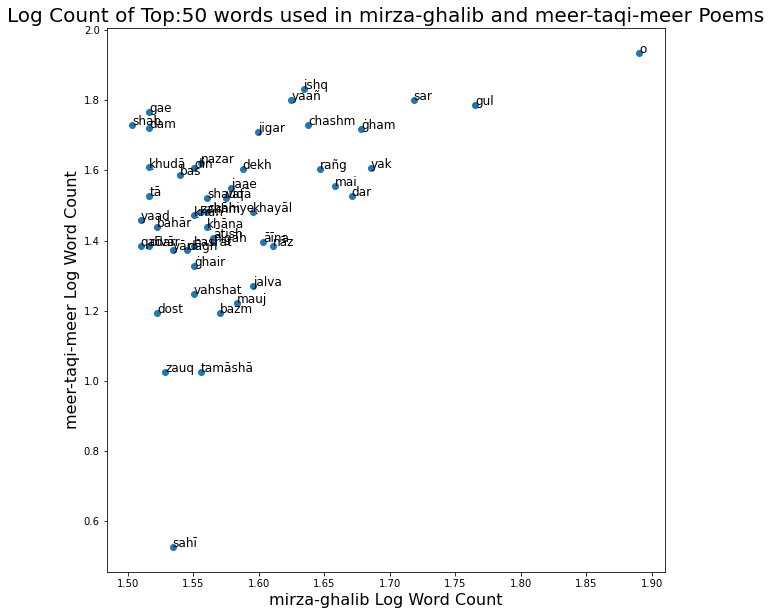

In [96]:
plotScatterPlot(df1,df2,poet1,poet2,50)

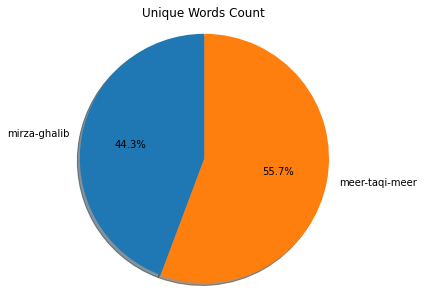

In [97]:
Pieplot(df1,df2,poet1,poet2)

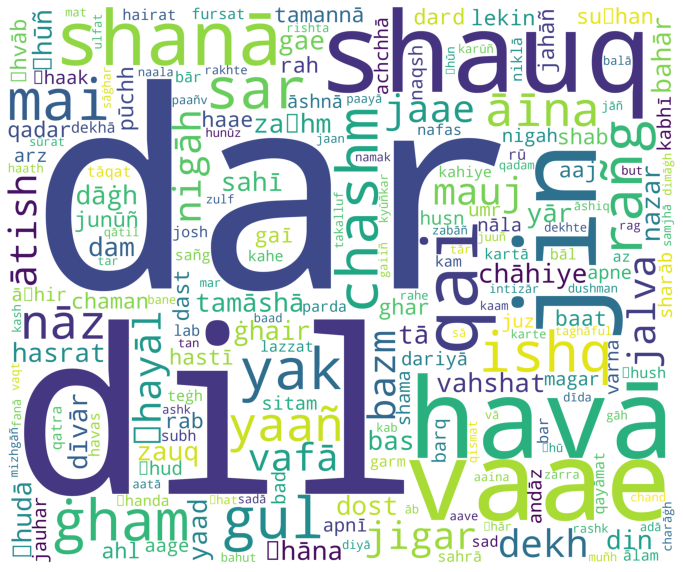

In [98]:
plotWordCloud(df1)

In [99]:
plotWordFrequencies(df1,10)

In [100]:
wordFrequencyComparisions(merged_words_df,10)

In [101]:
vocabTotalWordsComparisionPlot(authors_vocab_df)

## TEST Code